<a href="https://colab.research.google.com/github/winkler-eva/CovidClassifierBIOINF/blob/main/CovidClassifier_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>Covid-Classifier</strong></h1>

In [1]:
!pip install fastai --upgrade -q

In [2]:
import fastai
print(fastai.__version__)

2.3.0


In [3]:
import os
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

<h2>Save images permanently in google drive</h2>

In [4]:
# data was downloaded from the website kaggle.com
!tar -czvf covid_images.tar.gz covid_data

tar: covid_data: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [5]:
!cp -av covid_images.tar.gz /content/drive/My\ Drive/BIOINF

'covid_images.tar.gz' -> '/content/drive/My Drive/BIOINF/covid_images.tar.gz'


In [6]:
!cp /content/drive/My\ Drive/BIOINF/covid_images.tar.gz covid_project/ # replace 'test' with real folder name 

In [7]:
!tar -xf covid_project/covid_images.tar.gz -C covid_project/ # replace 'test' with real folder name 

<h2>Dataloader</h2>

In [8]:
path = Path('covid_project')
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);

In [9]:
covid = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    # splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
) 

In [10]:
dls = covid.dataloaders(path, bs=64)

<h2>Normalize trainings dataset</h2>

In [11]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.6650, 0.6649, 0.6650], device='cuda:0'),
 TensorImage([0.3131, 0.3134, 0.3133], device='cuda:0'))

In [12]:
def get_dls(bs, size):
  covid = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    # splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(460),
    batch_tfms = [*aug_transforms(size=224, min_scale=0.75),
                                Normalize.from_stats(*imagenet_stats)])
  return covid.dataloaders(path, bs=bs)

In [13]:
dls = get_dls(64, 224)

In [14]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.6039, 0.7447, 0.9632], device='cuda:0'),
 TensorImage([1.3961, 1.4277, 1.4208], device='cuda:0'))

In [15]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.013574,4.409195,0.741935,00:09
1,3.451161,1.807554,0.741935,00:06
2,2.387230,1.114708,0.741935,00:06
3,1.836942,0.830640,0.763441,00:06
4,1.499126,0.597587,0.741935,00:06


<h2>Progressive Resizing</h2>



In [16]:
# dls = get_dls(128, 128)
# learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
# learn.fit_one_cycle(4, 3e-3)

In [17]:
# learn.dls = get_dls(64, 224)
# learn.fine_tune(5, 5e-3)

<h2>Test-Time Augumentation</h2>

In [42]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.7956989407539368

<h2>Label Smoothing</h2>

In [43]:
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.472291,4.273188,0.419355,00:06
1,3.669651,4.790896,0.741935,00:06
2,2.980974,7.881727,0.623656,00:06
3,2.612469,5.846934,0.537634,00:06
4,2.363651,2.226375,0.741935,00:06


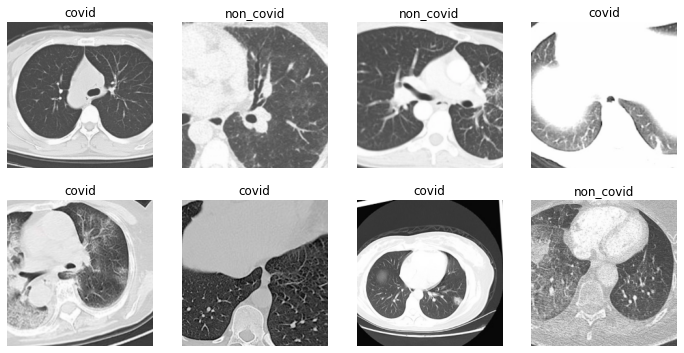

In [18]:
dls.show_batch(max_n=8, nrows=2)

<h2>Train learner</h2>

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.334134,0.729737,0.344086,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.952397,1.267365,0.548387,00:04
1,0.969773,1.207077,0.548387,00:04
2,0.911632,1.015747,0.397849,00:04
3,0.824475,1.057777,0.354839,00:04
4,0.773297,1.068132,0.376344,00:04
5,0.729707,0.911876,0.301075,00:04
6,0.663782,0.828521,0.311828,00:04
7,0.631708,0.776342,0.301075,00:04
8,0.578621,0.733080,0.290323,00:04
9,0.546969,0.719441,0.258065,00:04


<h2>Export learner</h2>

In [20]:
learn.export('covid_classifier.pkl')

In [21]:
# Check if path exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('covid_classifier.pkl')]

In [22]:
# Save covid_classifier.pkl on google drive
# !cp /content/covid_classifier.pkl /content/drive/My\ Drive/BIOINF/covid_classifier.pkl

<h2>Import learner + inference</h2>

In [23]:
# Uncomment line to copy learner from google drive
# !cp /content/drive/My\ Drive/BIOINF/covid_classifier.pkl ./ 

In [24]:
inference = load_learner(path/'covid_classifier.pkl')

In [25]:
# Save test image on google drive
# !cp /content/Testbild.jpeg /content/drive/My\ Drive/BIOINF/
!cp /content/drive/My\ Drive/BIOINF/Testbild.jpeg ./

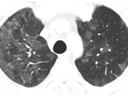

In [26]:
img = Image.open('Testbild.jpeg')
img.to_thumb(128,128)

In [28]:
# inference.predict('Testbild.jpeg')
# inference.predict('Testbild_gesund.jpg')

In [29]:
inference.dls.vocab

['covid', 'non_covid']

<h2>User Interface</h2>

In [31]:
import ipywidgets as widgets

In [32]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [33]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
pred, pred_idx, probs = inference.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: covid; Probability: 0.9529')

In [39]:
btn_run = widgets.Button(description='Classify Covid')
btn_run

Button(description='Classify Covid', style=ButtonStyle())

In [40]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = inference.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
btn_upload = widgets.FileUpload()
widgets.VBox([widgets.Label("Select lung CT:"),
             btn_upload, btn_run, out_pl, lbl_pred])